In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
    

In [2]:
from google.colab import drive
drive.mount('/content/drive')
     

Mounted at /content/drive


In [3]:
dataset_path='/content/drive/MyDrive/dataset/MontgomerySet'

In [4]:
# Load the dataset
def load_data(dataset_path, split=0.1):
    images = sorted(glob(os.path.join(dataset_path, "CXR_png", "*.png")))
    masks1 = sorted(glob(os.path.join(dataset_path, "ManualMask", "leftMask", "*.png")))
    masks2 = sorted(glob(os.path.join(dataset_path, "ManualMask", "rightMask", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y1, valid_y1 = train_test_split(masks1, test_size=split_size, random_state=42)
    train_y2, valid_y2 = train_test_split(masks2, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y1, test_y1 = train_test_split(train_y1, test_size=split_size, random_state=42)
    train_y2, test_y2 = train_test_split(train_y2, test_size=split_size, random_state=42)

    return (train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2), (test_x, test_y1, test_y2)

In [5]:
(train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2), (test_x, test_y1, test_y2) = load_data(dataset_path)

**U-Net architecture:**
The U-Net architecture is a convolutional neural network (CNN) that was originally designed for biomedical image segmentation tasks, but it has since been widely used in various computer vision applications. The name "U-Net" comes from its U-shaped architecture, where the network consists of a contracting path (encoder) and an expanding path (decoder).

Here's a high-level overview of the U-Net architecture:
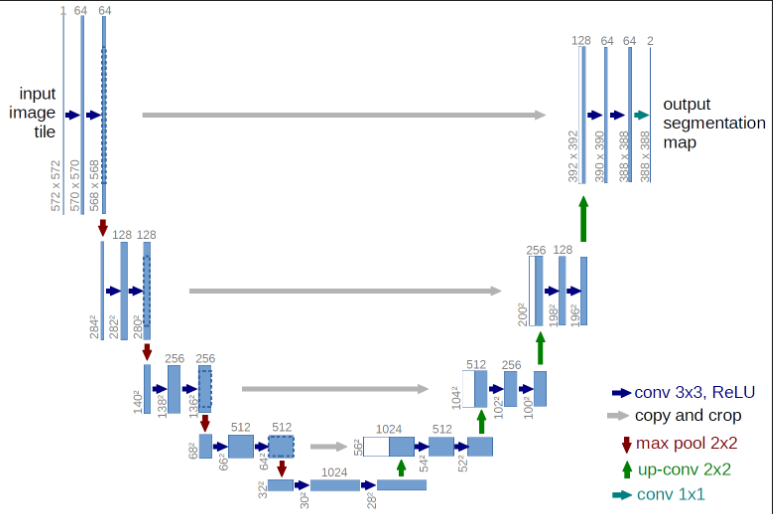

**Contracting Path (Encoder):**
The encoder part of the network is composed of multiple convolutional layers, each followed by a rectified linear unit (ReLU) activation function and max pooling operation.
These convolutional layers gradually reduce the spatial dimensions of the input image while increasing the number of feature channels.
The purpose of this path is to capture context and extract high-level features from the input image.

**Expanding Path (Decoder):**
The decoder part of the network is composed of up-convolutional layers (also known as transpose convolution or deconvolution), followed by a concatenation with the corresponding feature maps from the contracting path.
Each up-convolutional layer upsamples the feature maps and reduces the number of channels.
The purpose of this path is to recover spatial resolution and generate a detailed segmentation map.

**Skip Connections:**
One key aspect of the U-Net architecture is the use of skip connections.
Skip connections are formed by concatenating feature maps from the contracting path to the corresponding feature maps in the expanding path.
These connections help to preserve low-level details and enable the network to localize objects accurately.

**Final Layer:**
The final layer of the U-Net architecture typically consists of a 1x1 convolutional layer followed by a softmax activation function.
This layer produces the segmentation map, where each pixel is assigned a class probability, indicating the likelihood of belonging to a particular object or background.

The U-Net architecture has been successful in various image segmentation tasks, such as segmenting cells, organs, and other structures in biomedical images. It has also been adapted and extended for other computer vision tasks, including semantic segmentation, instance segmentation, and image-to-image translation.





In [17]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [18]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [19]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [20]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [27]:
input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [28]:
#Reading Images
H = 512
W = 512
def read_image(dataset_path):
    x = cv2.imread(dataset_path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

In [29]:
x = read_image(train_x[0])
print(x.shape)

(512, 512, 3)


In [30]:
#Reading Masks
def read_mask(path1, path2):
    x1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    x2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
    x = x1 + x2
    x = cv2.resize(x, (W, H))
    x = x/np.max(x)
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [31]:
x = read_mask(train_y1[0], train_y2[0])
print(x.shape)

(512, 512, 1)


In [33]:
# This function takes path for image and mask and gives tensor. To include the function which are not on tensorflow use numpy_function.

def tf_parse(x, y1, y2):
    def _parse(x, y1, y2):
        x = x.decode()
        y1 = y1.decode()
        y2 = y2.decode()

        x = read_image(x) # gives array
        y = read_mask(y1, y2)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y1, y2], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [34]:
def tf_dataset(X, Y1, Y2, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y1, Y2))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

In [35]:
print(f"Train: {len(train_x)} - {len(train_y1)} - {len(train_y2)}")
print(f"Valid: {len(valid_x)} - {len(valid_y1)} - {len(valid_y2)}")
print(f"Test: {len(test_x)} - {len(test_y1)} - {len(test_y2)}")

Train: 112 - 112 - 112
Valid: 13 - 13 - 13
Test: 13 - 13 - 13


In [36]:
batch_size = 2
lr = 1e-5
num_epochs = 20

In [37]:
train_dataset = tf_dataset(train_x, train_y1, train_y2, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y1, valid_y2, batch=batch_size)

**Defining Evaluation Metrics**

The Dice coefficient, also known as the  Dice similarity coefficient, is a measure of similarity between two sets or binary variables. 

The formula for calculating the Dice coefficient is:

Dice_coefficient = (2 * |A ∩ B|) / (|A| + |B|) 

In Image Segmentation,

A is the predicted set of pixels

B is the ground truth

Dice loss is a commonly used loss function in image segmentation tasks.

**Dice Loss = 1 - Dice Score**

IOU measures the overlap or similarity between two sets, typically represented as bounding boxes or segmentation masks.

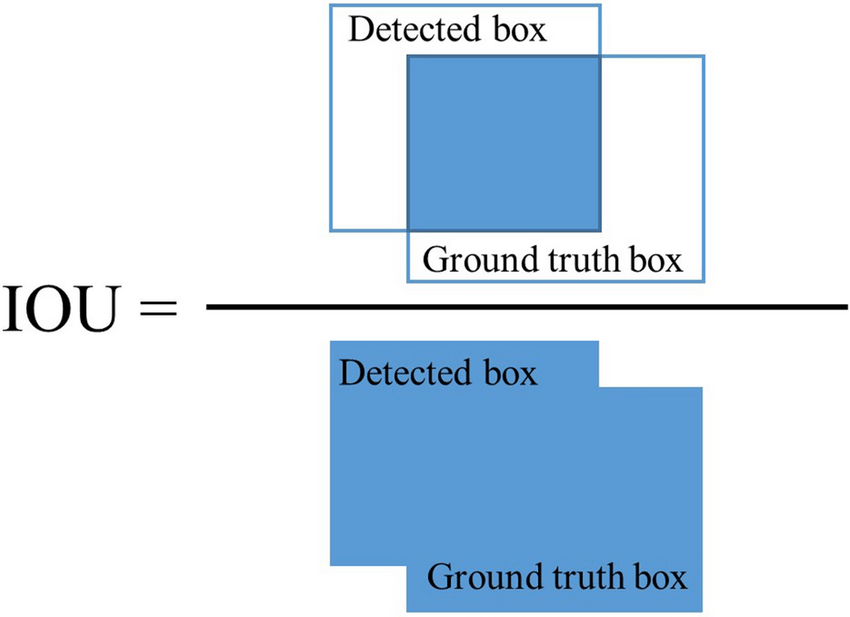




In [38]:
#Defining Evaluation Metrics
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

Model Building

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
model = build_unet((H, W, 3))
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

In [40]:
model_path = os.path.join("files", "model.h5")

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)
        
    ]

In [42]:

tf.config.optimizer.set_jit(True)


In [43]:
model_history = model.fit(train_dataset, epochs=num_epochs,
                          validation_data=valid_dataset,
                          callbacks=callbacks)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 0.4950 - dice_coef: 0.5050 - iou: 0.3451 - recall: 0.7779 - precision: 0.5553
Epoch 1: val_loss improved from inf to 0.66568, saving model to files/model.h5
56/56 [==============================] - 481s 7s/step - loss: 0.4950 - dice_coef: 0.5050 - iou: 0.3451 - recall: 0.7779 - precision: 0.5553 - val_loss: 0.6657 - val_dice_coef: 0.3219 - val_iou: 0.1942 - val_recall: 0.5761 - val_precision: 0.3253 - lr: 1.0000e-05
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 0.3304 - dice_coef: 0.6696 - iou: 0.5085 - recall: 0.9053 - precision: 0.6601
Epoch 2: val_loss improved from 0.66568 to 0.65367, saving model to files/model.h5
56/56 [==============================] - 66s 1s/step - loss: 0.3304 - dice_coef: 0.6696 - iou: 0.5085 - recall: 0.9053 - precision: 0.6601 - val_loss: 0.6537 - val_dice_coef: 0.3550 - val_iou: 0.2175 - val_recall: 0.7242 - val_precision: 0.3463 - lr: 1.0000e-05
Epoch 3/20
56/56 [===

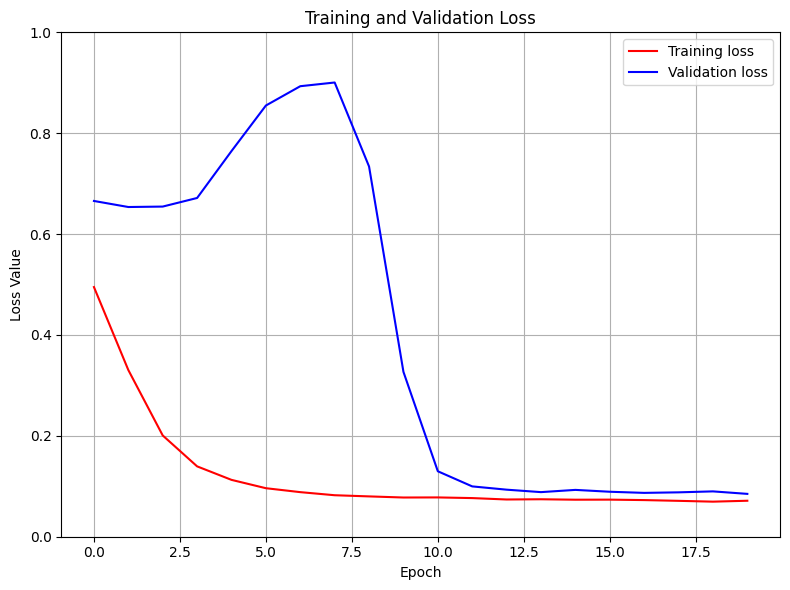

In [44]:
import matplotlib.pyplot as plt

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
# Utility function for visualizing images and masks
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
     

In [48]:
from tqdm import tqdm
for x, y1, y2 in tqdm(zip(test_x, test_y1, test_y2), total=len(test_x)):
  image_name = x.split("/")[-1]

  # Reading the image
  ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
  ori_x = cv2.resize(ori_x, (W, H))
  x = ori_x/255.0
  x = x.astype(np.float32)
  x = np.expand_dims(x, axis=0)

  # Reading the mask 
  ori_y1 = cv2.imread(y1, cv2.IMREAD_GRAYSCALE)
  ori_y2 = cv2.imread(y2, cv2.IMREAD_GRAYSCALE)
  ori_y = ori_y1 + ori_y2
  ori_y = cv2.resize(ori_y, (W, H))
  ori_y = np.expand_dims(ori_y, axis=-1)  ## (512, 512, 1)
  ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)  ## (512, 512, 3) number of channels increased from 1 to 3

  # Predicting the mask
  y_pred = model.predict(x)[0] > 0.5
  y_pred = y_pred.astype(np.int32)

  #  Saving the predicted mask along with the image and ground
  save_image_path = f"result/{image_name}"
  y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

  sep_line = np.ones((H, 10, 3)) * 255

  cat_image = np.concatenate([ori_x, sep_line, ori_y, sep_line, y_pred*255], axis=1)
  cv2.imwrite(save_image_path, cat_image)
     

  0%|          | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 1/13 [00:06<01:13,  6.09s/it]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 2/13 [00:09<00:47,  4.35s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 3/13 [00:12<00:40,  4.00s/it]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 4/13 [00:16<00:33,  3.71s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 5/13 [00:19<00:28,  3.60s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 6/13 [00:22<00:24,  3.49s/it]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 7/13 [00:26<00:21,  3.63s/it]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 8/13 [00:30<00:18,  3.69s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 9/13 [00:34<00:14,  3.69s/it]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 10/13 [00:37<00:10,  3.60s/it]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 11/13 [00:42<00:07,  3.93s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 12/13 [00:45<00:03,  3.66s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 13/13 [00:48<00:00,  3.73s/it]


In [49]:
pred_mask = model.predict(x)[0] > 0.5
pred_mask = pred_mask.astype(np.int32)

1/1 [==============================] - 0s 26ms/step


In [50]:
pred_mask = np.concatenate([pred_mask, pred_mask, pred_mask], axis=-1)
     

  0%|          | 0/13 [00:00<?, ?it/s]

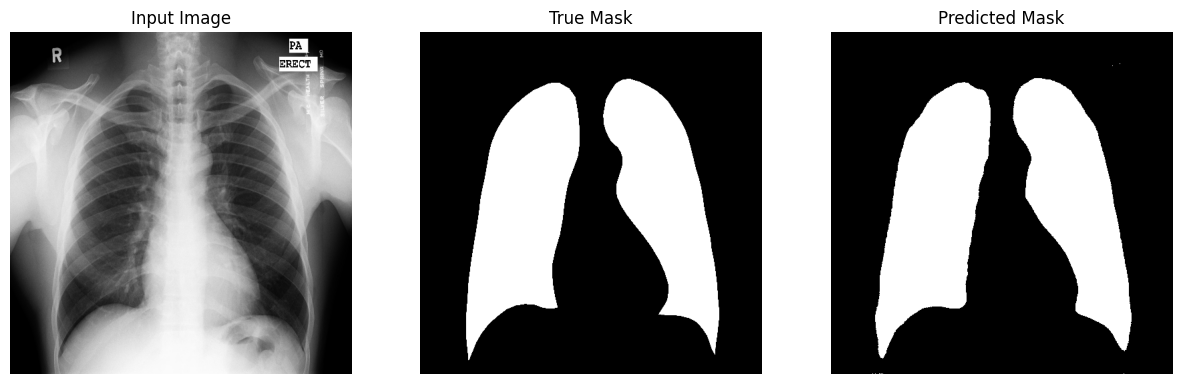

  8%|▊         | 1/13 [00:00<00:04,  2.45it/s]

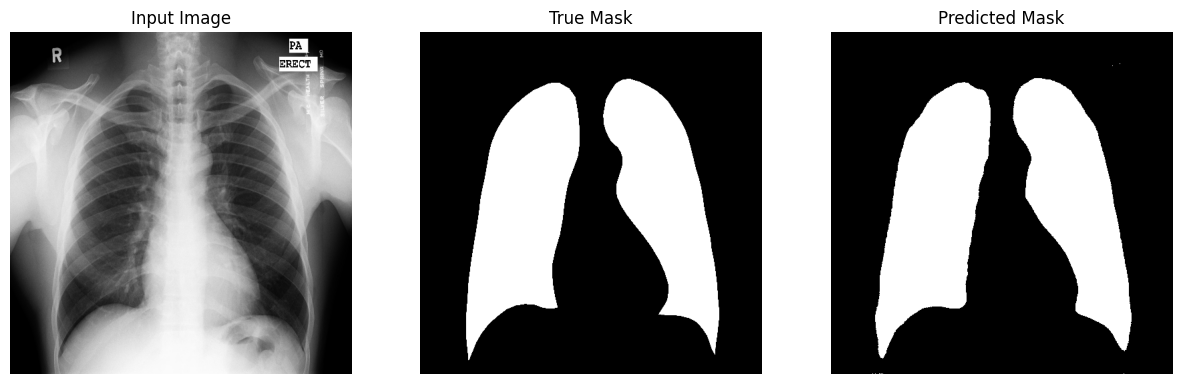

 15%|█▌        | 2/13 [00:00<00:04,  2.38it/s]

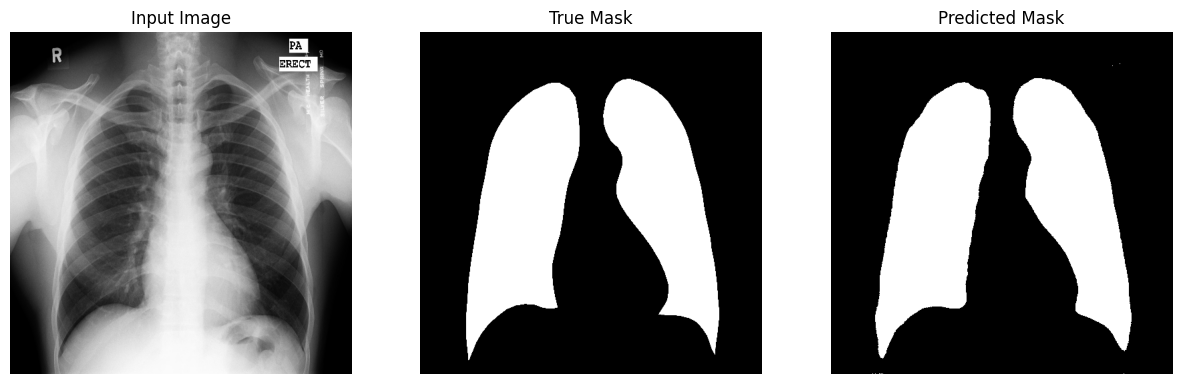

 23%|██▎       | 3/13 [00:01<00:04,  2.46it/s]

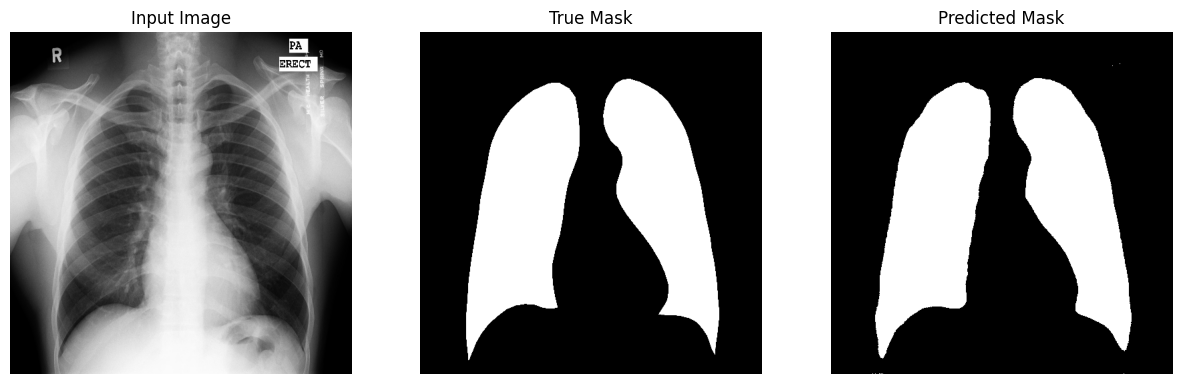

 31%|███       | 4/13 [00:01<00:04,  1.99it/s]

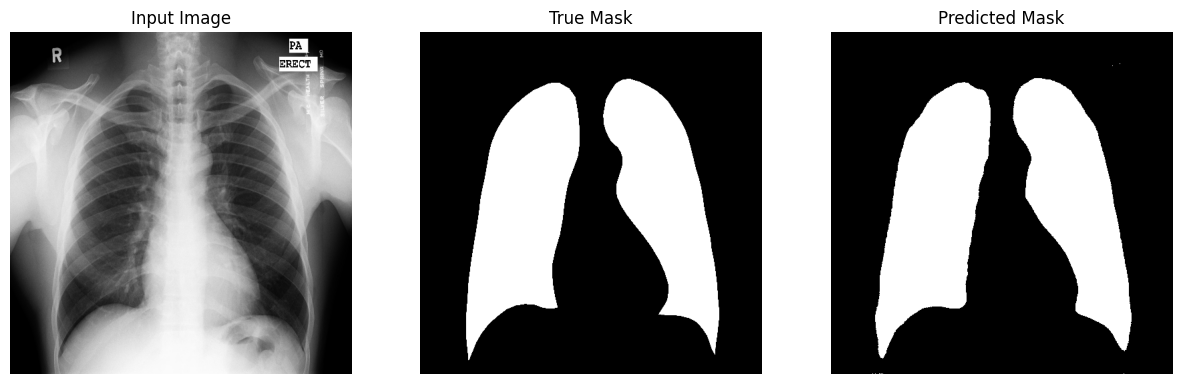

 38%|███▊      | 5/13 [00:02<00:03,  2.09it/s]

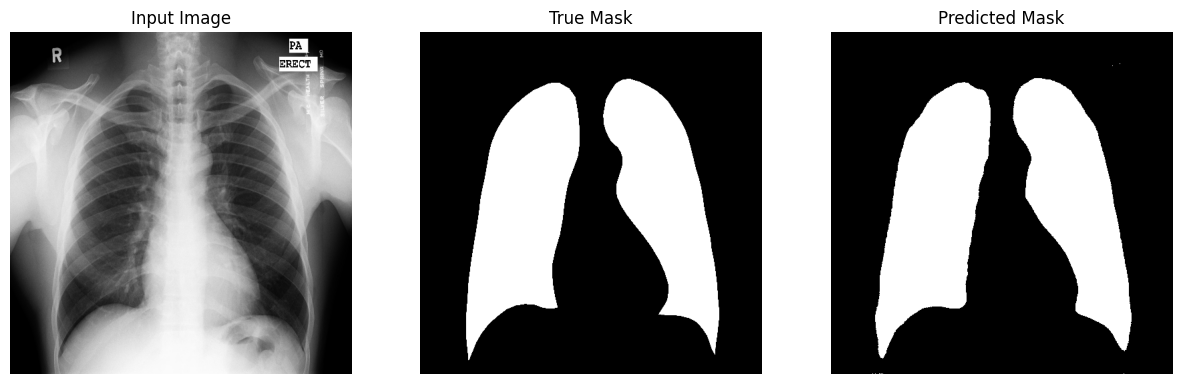

 46%|████▌     | 6/13 [00:02<00:03,  2.14it/s]

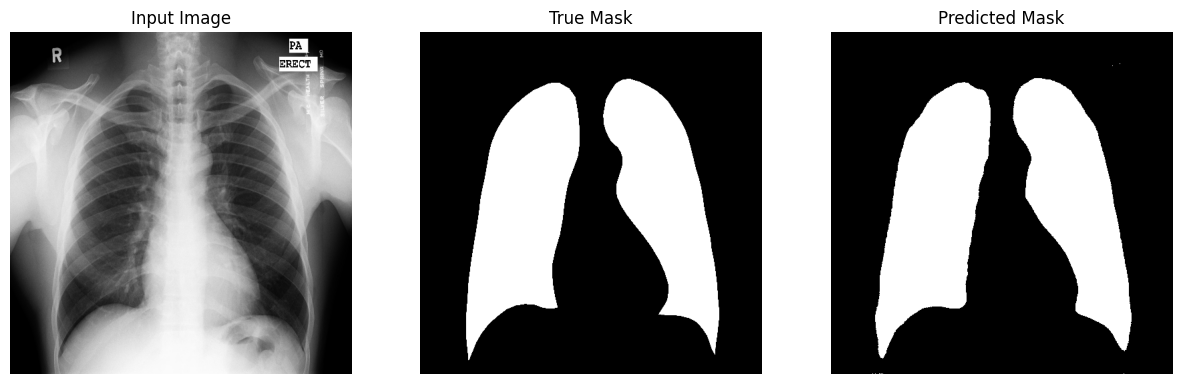

 54%|█████▍    | 7/13 [00:03<00:02,  2.18it/s]

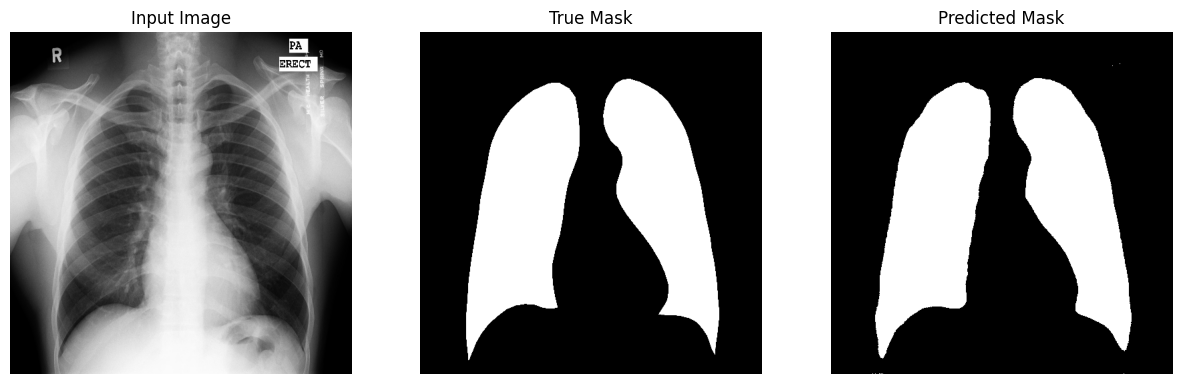

 62%|██████▏   | 8/13 [00:04<00:02,  1.76it/s]

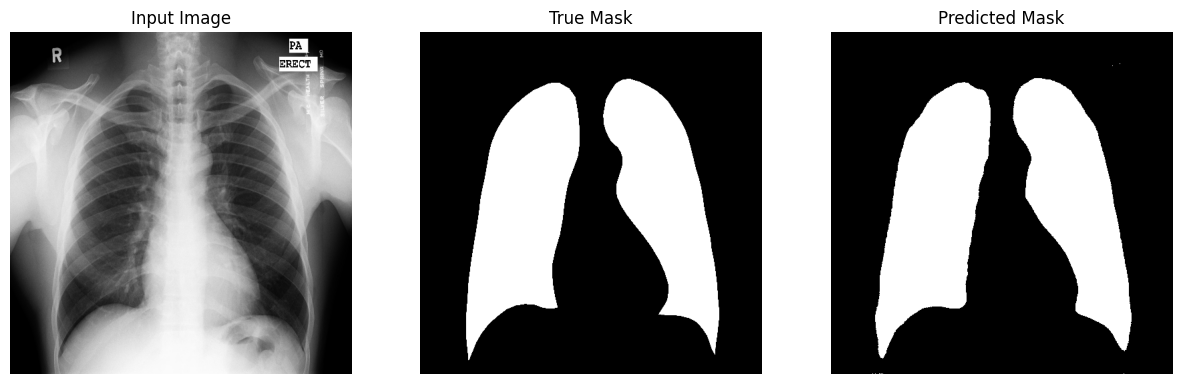

 69%|██████▉   | 9/13 [00:04<00:02,  1.42it/s]

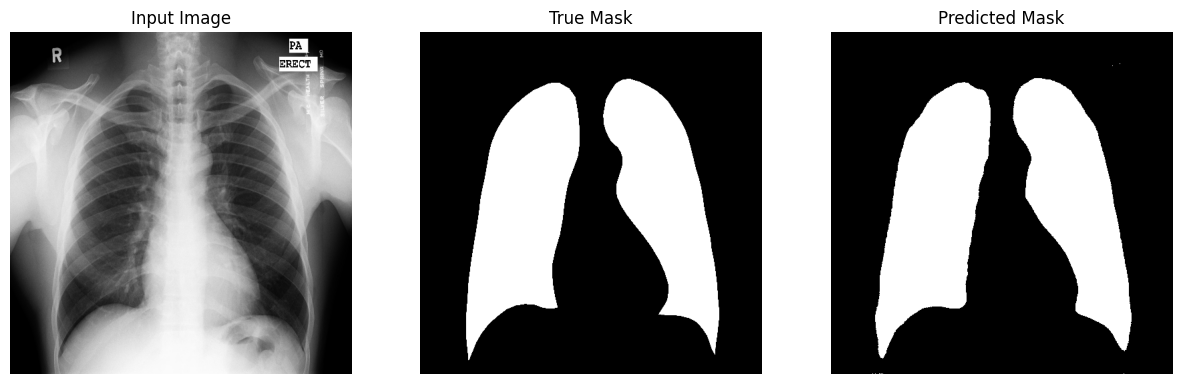

 77%|███████▋  | 10/13 [00:05<00:02,  1.35it/s]

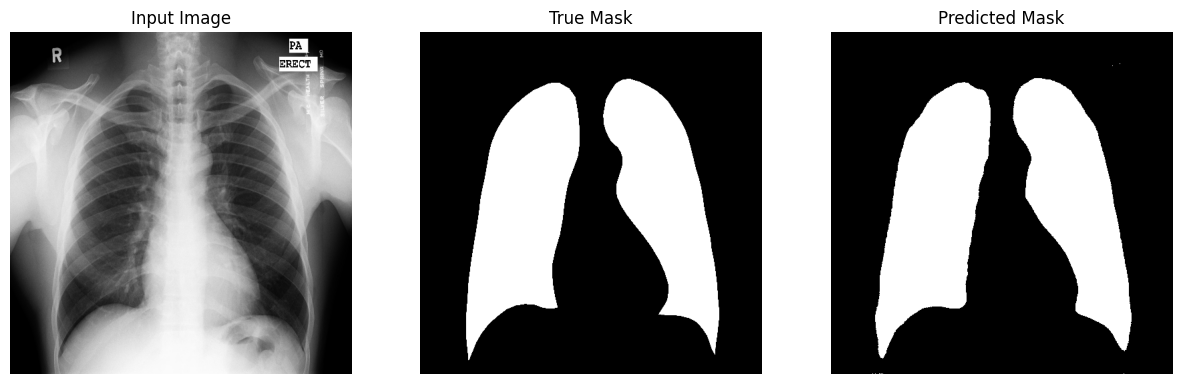

 85%|████████▍ | 11/13 [00:06<00:01,  1.56it/s]

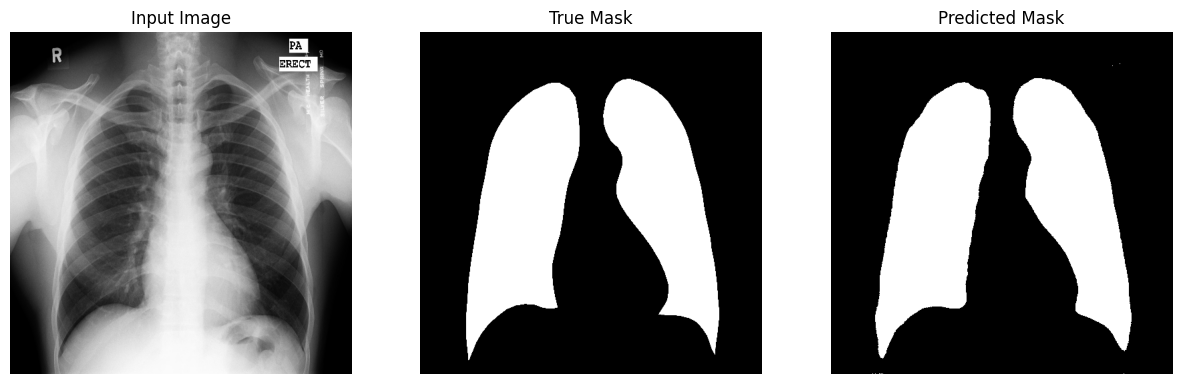

 92%|█████████▏| 12/13 [00:06<00:00,  1.73it/s]

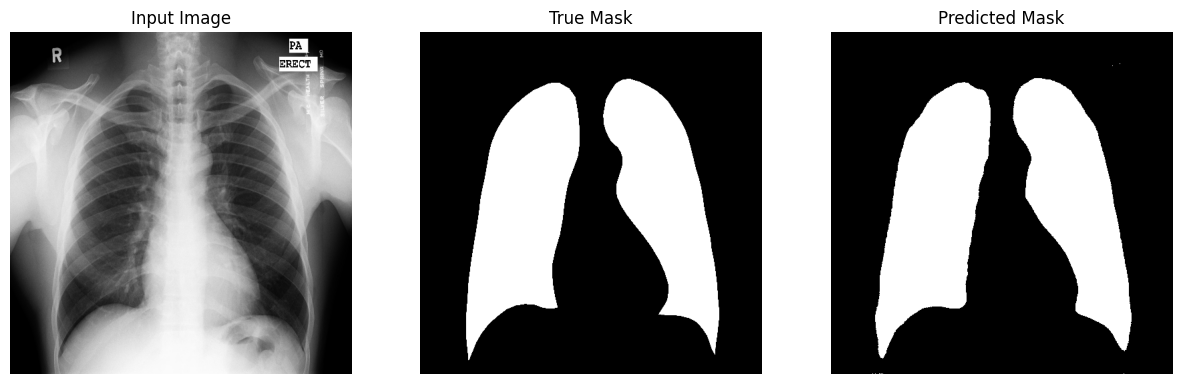

100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


In [51]:
for x, y1, y2 in tqdm(zip(test_x, test_y1, test_y2), total=len(test_x)):
  display([ori_x, ori_y, pred_mask])